# Classification script

In [1]:
print("RADAR CLASSIFICATION - CORRECT METHODOLOGY")
print("=" * 50)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

# Load data
df = pd.read_csv("cfar_out/individual_detections_ml.csv")
print(f"Loaded data: {df.shape}")

# Basic info
print(f"Total detections: {len(df)}")
print(f"Driving: {len(df[df['target_type'] == 'driving'])}")
print(f"Walking: {len(df[df['target_type'] == 'walking'])}")
print(f"Unique files: {df['filename'].nunique()}")

RADAR CLASSIFICATION - CORRECT METHODOLOGY
Loaded data: (28750, 13)
Total detections: 28750
Driving: 20341
Walking: 8409
Unique files: 48


In [2]:
print("FEATURE ENGINEERING AND SELECTION")
print("=" * 50)


def parse_spectrum_peaks(peaks_str):
    try:
        peaks = peaks_str.strip('[]').split(',')
        return [float(p.strip()) for p in peaks if p.strip()]
    except:
        return []

df['spectrum_peaks_list'] = df['spectrum_peaks_hz'].apply(parse_spectrum_peaks)
df['max_spectrum_peak'] = df['spectrum_peaks_list'].apply(lambda x: max(x) if x else 0)

# Create ratio features
df['doppler_to_speed_ratio'] = df['doppler_bandwidth_hz'] / (df['average_speed_kmh'] + 1e-8)
df['snr_to_rcs_ratio'] = df['snr_db'] / (df['rcs_estimate'] + 1e-8)
df['speed_std_normalized'] = df['speed_variance'] ** 0.5 / (df['average_speed_kmh'] + 1e-8)


selected_features = [
    # Basic radar features
    'average_speed_kmh',      # Use speed instead of frequency
    'snr_db',
    'rcs_estimate', 
    'signal_intensity',
    'speed_variance',
    'doppler_bandwidth_hz',
    'spectrum_std_hz',
    
    # Engineered features
    'max_spectrum_peak',
    'speed_std_normalized',
    'doppler_to_speed_ratio',
    'snr_to_rcs_ratio'
]

print("Selected 11 individual detection features (no file-level features):")
for i, feat in enumerate(selected_features, 1):
    print(f"{i:2d}. {feat}")

X = df[selected_features]
y = LabelEncoder().fit_transform(df['target_type'])

print(f"\nFeature matrix shape: {X.shape}")
print(f"Class distribution: Driving={np.sum(y == 0)}, Walking={np.sum(y == 1)}")

FEATURE ENGINEERING AND SELECTION
Selected 11 individual detection features (no file-level features):
 1. average_speed_kmh
 2. snr_db
 3. rcs_estimate
 4. signal_intensity
 5. speed_variance
 6. doppler_bandwidth_hz
 7. spectrum_std_hz
 8. max_spectrum_peak
 9. speed_std_normalized
10. doppler_to_speed_ratio
11. snr_to_rcs_ratio

Feature matrix shape: (28750, 11)
Class distribution: Driving=20341, Walking=8409


In [3]:
print("CORRECT FILE-LEVEL SPLITTING")
print("=" * 50)

# Get file information
file_info = df[['filename', 'target_type']].drop_duplicates()
file_info['target_encoded'] = y[file_info.index]

print(f"Total files: {len(file_info)}")
print(f"Driving files: {len(file_info[file_info['target_type'] == 'driving'])}")
print(f"Walking files: {len(file_info[file_info['target_type'] == 'walking'])}")

# Split files into CV set (36 files) and Final Test set (12 files)
files_cv, files_test = train_test_split(
    file_info['filename'], 
    test_size=12,  # Exactly 12 files for test
    random_state=42, 
    stratify=file_info['target_encoded']
)

print(f"\nFILE-LEVEL SPLITS:")
print(f"CV/Training files: {len(files_cv)}")
print(f"Final Test files: {len(files_test)}")

# Get detections for each split
cv_mask = df['filename'].isin(files_cv)
test_mask = df['filename'].isin(files_test)

X_cv = df[cv_mask][selected_features]
y_cv = y[cv_mask]
X_test = df[test_mask][selected_features]
y_test = y[test_mask]

print(f"\nDetection counts:")
print(f"CV set: {X_cv.shape[0]} detections from {len(files_cv)} files")
print(f"Test set: {X_test.shape[0]} detections from {len(files_test)} files")

print(f"\nClass distribution:")
print(f"CV - Driving: {np.sum(y_cv == 0)} ({np.sum(y_cv == 0)/len(y_cv)*100:.1f}%)")
print(f"Test - Driving: {np.sum(y_test == 0)} ({np.sum(y_test == 0)/len(y_test)*100:.1f}%)")

# Verify no data leaks
cv_files = df[cv_mask]['filename'].unique()
test_files = df[test_mask]['filename'].unique()
overlap = set(cv_files) & set(test_files)

print(f"\nDATA LEAK CHECK:")
print(f"Files in both CV and test: {len(overlap)}")
if len(overlap) == 0:
    print("SUCCESS: No data leaks - perfect file-level splitting")
else:
    print("DATA LEAK DETECTED")
    

CORRECT FILE-LEVEL SPLITTING
Total files: 48
Driving files: 24
Walking files: 24

FILE-LEVEL SPLITS:
CV/Training files: 36
Final Test files: 12

Detection counts:
CV set: 21227 detections from 36 files
Test set: 7523 detections from 12 files

Class distribution:
CV - Driving: 14965 (70.5%)
Test - Driving: 5376 (71.5%)

DATA LEAK CHECK:
Files in both CV and test: 0
SUCCESS: No data leaks - perfect file-level splitting


In [4]:
# print("5-FOLD STRATIFIED CROSS VALIDATION")
print("=" * 50)

print("Performing K-fold CV at FILE level:")
print("- Training on files from 4 folds, testing on files from 1 fold")
print("- All detections from a file stay together")
print("- Models tested on completely unseen files")

# Get the CV files and their classes
cv_files_info = file_info[file_info['filename'].isin(files_cv)]
cv_file_names = cv_files_info['filename'].values
cv_file_targets = cv_files_info['target_encoded'].values

print(f"\nCV Files: {len(cv_file_names)}")
print(f"CV File classes: Driving={np.sum(cv_file_targets == 0)}, Walking={np.sum(cv_file_targets == 1)}")

# Perform 5-fold stratified CV at FILE level
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

# Define all models
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
    'SVM Linear': SVC(kernel='linear', random_state=42, class_weight='balanced'),
    'SVM RBF': SVC(kernel='rbf', random_state=42, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'MLP': MLPClassifier(random_state=42, max_iter=1000, hidden_layer_sizes=(100, 50))
}

kfold_results = {}

print(f"\nRunning {k}-Fold Cross Validation...")
print("=" * 40)

for name, model in models.items():
    fold_scores = []
    
    print(f"\n{name}:")
    for fold, (train_file_idx, val_file_idx) in enumerate(skf.split(cv_file_names, cv_file_targets)):
        # Get file names for this fold
        train_files_fold = cv_file_names[train_file_idx]
        val_files_fold = cv_file_names[val_file_idx]
        
        # Get detections for these files
        train_mask_fold = df['filename'].isin(train_files_fold)
        val_mask_fold = df['filename'].isin(val_files_fold)
        
        X_train_fold = df[train_mask_fold][selected_features]
        X_val_fold = df[val_mask_fold][selected_features]
        y_train_fold = y[train_mask_fold]
        y_val_fold = y[val_mask_fold]
        
        # Scale features for this fold
        scaler_fold = StandardScaler()
        X_train_scaled = scaler_fold.fit_transform(X_train_fold)
        X_val_scaled = scaler_fold.transform(X_val_fold)
        
        # Train and evaluate
        model.fit(X_train_scaled, y_train_fold)
        val_score = accuracy_score(y_val_fold, model.predict(X_val_scaled))
        fold_scores.append(val_score)
        
        print(f"  Fold {fold+1}: {len(train_files_fold)} train files, {len(val_files_fold)} val files | Acc: {val_score:.4f}")
    
    kfold_results[name] = {
        'fold_scores': fold_scores,
        'mean_score': np.mean(fold_scores),
        'std_score': np.std(fold_scores)
    }
    
    print(f"  Average: {np.mean(fold_scores):.4f} ± {np.std(fold_scores)*2:.4f}")

# Display K-fold results
print("\n" + "=" * 60)
print("5-FOLD CROSS VALIDATION RESULTS")
print("=" * 60)

kfold_summary = []
for name in models.keys():
    kfold_summary.append({
        'Model': name,
        'Mean_CV_Accuracy': kfold_results[name]['mean_score'],
        'Std_CV_Accuracy': kfold_results[name]['std_score'],
        'CV_Range': f"{kfold_results[name]['mean_score']:.4f} ± {kfold_results[name]['std_score']*2:.4f}"
    })

kfold_df = pd.DataFrame(kfold_summary).round(4)
kfold_df = kfold_df.sort_values('Mean_CV_Accuracy', ascending=False)

print(kfold_df.to_string(index=False))

Performing K-fold CV at FILE level:
- Training on files from 4 folds, testing on files from 1 fold
- All detections from a file stay together
- Models tested on completely unseen files

CV Files: 36
CV File classes: Driving=18, Walking=18

Running 5-Fold Cross Validation...

Logistic Regression:
  Fold 1: 28 train files, 8 val files | Acc: 0.8837
  Fold 2: 29 train files, 7 val files | Acc: 0.9425
  Fold 3: 29 train files, 7 val files | Acc: 0.8884
  Fold 4: 29 train files, 7 val files | Acc: 0.9348
  Fold 5: 29 train files, 7 val files | Acc: 0.8231
  Average: 0.8945 ± 0.0857

SVM Linear:
  Fold 1: 28 train files, 8 val files | Acc: 0.9141
  Fold 2: 29 train files, 7 val files | Acc: 0.9533
  Fold 3: 29 train files, 7 val files | Acc: 0.9049
  Fold 4: 29 train files, 7 val files | Acc: 0.9398
  Fold 5: 29 train files, 7 val files | Acc: 0.8417
  Average: 0.9108 ± 0.0773

SVM RBF:
  Fold 1: 28 train files, 8 val files | Acc: 0.9012
  Fold 2: 29 train files, 7 val files | Acc: 0.9683
  

In [5]:
print("FINAL EVALUATION ON 12 UNSEEN TEST FILES")
print("=" * 50)

print("Testing on completely unseen files that were NEVER used during CV:")
print(f"Test files: {len(files_test)}")
print(f"Test detections: {X_test.shape[0]}")

# Scale the data
scaler_final = StandardScaler()
X_cv_scaled = scaler_final.fit_transform(X_cv)
X_test_scaled = scaler_final.transform(X_test)

# Train final models on ALL CV data and test on unseen files
final_results = {}

print(f"\nTraining on ALL {len(files_cv)} CV files, testing on {len(files_test)} unseen files...")
for name, model in models.items():
    # Train on all CV data
    model.fit(X_cv_scaled, y_cv)
    
    # Test on completely unseen files
    test_pred = model.predict(X_test_scaled)
    test_acc = accuracy_score(y_test, test_pred)
    
    final_results[name] = {
        'cv_mean': kfold_results[name]['mean_score'],
        'cv_std': kfold_results[name]['std_score'],
        'test_accuracy': test_acc
    }
    
    print(f"{name:20} | CV: {kfold_results[name]['mean_score']:.4f} ± {kfold_results[name]['std_score']*2:.4f} | Test: {test_acc:.4f}")

# Final results table
print("\n" + "=" * 70)
print("FINAL RESULTS - PROPER FILE-LEVEL EVALUATION")
print("=" * 70)

final_df = pd.DataFrame(final_results).T.round(4)
final_df = final_df.sort_values('test_accuracy', ascending=False)

print(final_df)

print(f"\nBEST MODEL: {final_df.index[0]}")
print(f"5-Fold CV: {final_df.iloc[0]['cv_mean']:.1%} ± {final_df.iloc[0]['cv_std']*2:.1%}")
print(f"Final Test: {final_df.iloc[0]['test_accuracy']:.1%}")
print(f"Literature Comparison: 85-96%")

FINAL EVALUATION ON 12 UNSEEN TEST FILES
Testing on completely unseen files that were NEVER used during CV:
Test files: 12
Test detections: 7523

Training on ALL 36 CV files, testing on 12 unseen files...
Logistic Regression  | CV: 0.8945 ± 0.0857 | Test: 0.8692
SVM Linear           | CV: 0.9108 ± 0.0773 | Test: 0.8741
SVM RBF              | CV: 0.9348 ± 0.0745 | Test: 0.9329
Random Forest        | CV: 0.9340 ± 0.1171 | Test: 0.9331
Gradient Boosting    | CV: 0.9316 ± 0.1069 | Test: 0.9230
MLP                  | CV: 0.9359 ± 0.0969 | Test: 0.9373

FINAL RESULTS - PROPER FILE-LEVEL EVALUATION
                     cv_mean  cv_std  test_accuracy
MLP                   0.9359  0.0485         0.9373
Random Forest         0.9340  0.0585         0.9331
SVM RBF               0.9348  0.0372         0.9329
Gradient Boosting     0.9316  0.0535         0.9230
SVM Linear            0.9108  0.0387         0.8741
Logistic Regression   0.8945  0.0428         0.8692

BEST MODEL: MLP
5-Fold CV: 93.6% ± 9

DETAILED PERFORMANCE ANALYSIS


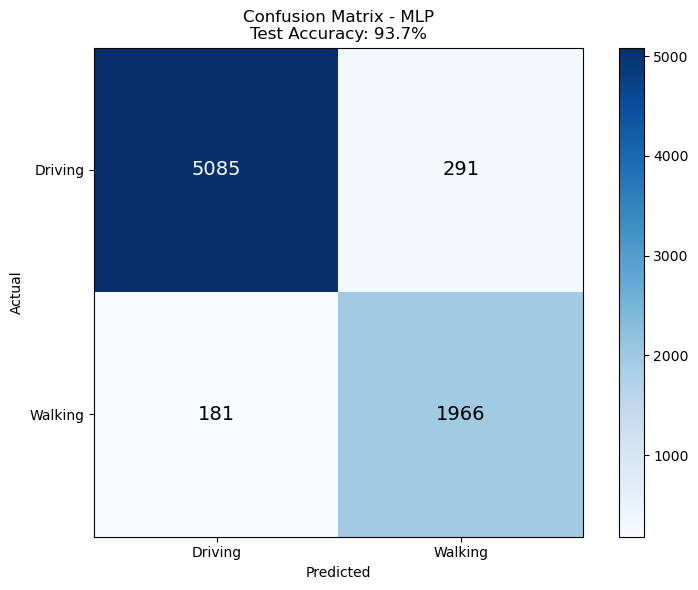


DETAILED CLASSIFICATION REPORT - MLP:
              precision    recall  f1-score   support

     Driving       0.97      0.95      0.96      5376
     Walking       0.87      0.92      0.89      2147

    accuracy                           0.94      7523
   macro avg       0.92      0.93      0.92      7523
weighted avg       0.94      0.94      0.94      7523


PERFORMANCE CONSISTENCY:
CV-Test Consistency: +0.001
(Positive values indicate good generalization to unseen data)

MODEL STABILITY (CV Standard Deviation):
  Logistic Regression : 0.0428 (Medium stability)
  SVM Linear          : 0.0387 (Medium stability)
  SVM RBF             : 0.0372 (Medium stability)
  Random Forest       : 0.0585 (Variable stability)
  Gradient Boosting   : 0.0535 (Variable stability)
  MLP                 : 0.0485 (Medium stability)


In [6]:
print("DETAILED PERFORMANCE ANALYSIS")
print("=" * 50)

# Get best model predictions
best_model_name = final_df.index[0]
best_model = models[best_model_name]

# Scale the test data (already done, but for clarity)
X_test_scaled = scaler_final.transform(X_test)
y_pred_best = best_model.predict(X_test_scaled)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(8, 6))
plt.imshow(cm, cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name}\nTest Accuracy: {final_results[best_model_name]["test_accuracy"]:.1%}')
plt.colorbar()
plt.xticks([0, 1], ['Driving', 'Walking'])
plt.yticks([0, 1], ['Driving', 'Walking'])
plt.xlabel('Predicted')
plt.ylabel('Actual')

for i in range(2):
    for j in range(2):
        plt.text(j, i, f'{cm[i, j]}', 
                horizontalalignment='center',
                verticalalignment='center',
                color='white' if cm[i, j] > cm.max()/2 else 'black',
                fontsize=14)

plt.tight_layout()
plt.show()

# Detailed classification report
print(f"\nDETAILED CLASSIFICATION REPORT - {best_model_name}:")
print("=" * 45)
cr = classification_report(y_test, y_pred_best, target_names=['Driving', 'Walking'], output_dict=False)
print(cr)

# Performance consistency analysis
print(f"\nPERFORMANCE CONSISTENCY:")
print(f"CV-Test Consistency: {final_results[best_model_name]['test_accuracy'] - final_results[best_model_name]['cv_mean']:+.3f}")
print("(Positive values indicate good generalization to unseen data)")

print(f"\nMODEL STABILITY (CV Standard Deviation):")
for name in final_results.keys():
    cv_std = final_results[name]['cv_std']
    stability = "High" if cv_std < 0.03 else "Medium" if cv_std < 0.05 else "Variable"
    print(f"  {name:20}: {cv_std:.4f} ({stability} stability)")

# DEEP LEARNING``

In [9]:
print("DEEP LEARNING MODELS WITH CORRECT FILE-LEVEL SPLITTING")
print("=" * 50)

print("Training 1D CNN and 2D CNN using the same file-level splits")
print("to ensure fair comparison with traditional models")

# We'll use the same file splits from our correct approach
print(f"Using same splits: {len(files_cv)} CV files, {len(files_test)} test files")

# Get the data using the same masks we defined earlier
X_cv_dl = df[cv_mask][selected_features].values
X_test_dl = df[test_mask][selected_features].values
y_cv_dl = y_cv
y_test_dl = y_test

print(f"\nData shapes:")
print(f"CV set: {X_cv_dl.shape}")
print(f"Test set: {X_test_dl.shape}")

DEEP LEARNING MODELS WITH CORRECT FILE-LEVEL SPLITTING
Training 1D CNN and 2D CNN using the same file-level splits
to ensure fair comparison with traditional models
Using same splits: 36 CV files, 12 test files

Data shapes:
CV set: (21227, 11)
Test set: (7523, 11)


In [14]:
import tensorflow as tf
print("1D CNN")
print("=" * 30)

cv_file_names = files_cv.values
cv_file_targets = file_info[file_info['filename'].isin(files_cv)]['target_encoded'].values

k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
cnn_1d_fold_scores = []

print(f"Running {k}-Fold CV...")
for fold, (train_file_idx, val_file_idx) in enumerate(skf.split(cv_file_names, cv_file_targets)):
    train_files = cv_file_names[train_file_idx]
    val_files = cv_file_names[val_file_idx]
    
    train_mask = df['filename'].isin(train_files)
    val_mask = df['filename'].isin(val_files)
    
    X_train = df[train_mask][selected_features].values
    X_val = df[val_mask][selected_features].values
    y_train = y[train_mask]
    y_val = y[val_mask]
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    X_train_1d = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
    X_val_1d = X_val_scaled.reshape(X_val_scaled.shape[0], X_val_scaled.shape[1], 1)
    
    # More stable architecture
    model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(32, 3, activation='relu', input_shape=(11, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(16, 2, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), 
                  loss='binary_crossentropy', metrics=['accuracy'])
    
    history = model.fit(
        X_train_1d, y_train,
        validation_data=(X_val_1d, y_val),
        epochs=25,
        batch_size=32,
        verbose=0
    )
    
    best_val_acc = max(history.history['val_accuracy'])
    cnn_1d_fold_scores.append(best_val_acc)
    print(f"Fold {fold+1}: {best_val_acc:.4f}")

# Final model
print("\nTraining final model...")
scaler_final = StandardScaler()
X_cv_scaled = scaler_final.fit_transform(X_cv_dl)
X_test_scaled = scaler_final.transform(X_test_dl)

X_cv_1d = X_cv_scaled.reshape(X_cv_scaled.shape[0], X_cv_scaled.shape[1], 1)
X_test_1d = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

final_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(32, 3, activation='relu', input_shape=(11, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Conv1D(16, 2, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

final_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                    loss='binary_crossentropy', metrics=['accuracy'])

final_model.fit(X_cv_1d, y_cv_dl, epochs=25, batch_size=32, verbose=0)
test_acc = final_model.evaluate(X_test_1d, y_test_dl, verbose=0)[1]

# Results
cv_mean = np.mean(cnn_1d_fold_scores)
cv_std = np.std(cnn_1d_fold_scores)

print(f"\nFINAL RESULTS:")
print(f"5-Fold CV: {cv_mean:.1%} ± {cv_std*2:.1%}")
print(f"Test Accuracy: {test_acc:.1%}")
print(f"Fold range: {min(cnn_1d_fold_scores):.1%} - {max(cnn_1d_fold_scores):.1%}")
print(f"Model params: {final_model.count_params():,}")

final_results['1D CNN'] = {
    'cv_mean': cv_mean,
    'cv_std': cv_std,
    'test_accuracy': test_acc
}

1D CNN
Running 5-Fold CV...
Fold 1: 0.9193
Fold 2: 0.9334
Fold 3: 0.9350
Fold 4: 0.9695
Fold 5: 0.9492

Training final model...

FINAL RESULTS:
5-Fold CV: 94.1% ± 3.4%
Test Accuracy: 90.5%
Fold range: 91.9% - 96.9%
Model params: 1,377


2D CNN ON SPECTROGRAMS FROM WAV FILES WITH 5-FOLD CV
Processing WAV files to create spectrograms for 2D CNN
Using 5-fold cross-validation for fair comparison
found 48 wav files
Processing WAV files into spectrograms...
Created 48 spectrograms
Shape of spectrogram data: (48, 128, 128)
Final shape for 2D CNN: (48, 128, 128, 1)

CV spectrogram files: 36
Driving: 18, Walking: 18

Running 5-Fold Cross Validation for 2D CNN...

Fold 1:
  Train spectrograms: 28
  Val spectrograms: 8
  Data shapes - Train: (28, 128, 128, 1), Val: (8, 128, 128, 1)

  Training 2D CNN...
Epoch 1/100
4/4 [==============================] - 3s 220ms/step - loss: 0.5638 - accuracy: 0.6071 - val_loss: 0.6927 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/100
4/4 [==============================] - 0s 80ms/step - loss: 0.4692 - accuracy: 0.8929 - val_loss: 0.6930 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/100
4/4 [==============================] - 0s 82ms/step - loss: 0.4543 - accuracy: 0.8214 - val_loss: 0.6935 - val_acc

Epoch 4/100
4/4 [==============================] - 0s 87ms/step - loss: 0.5578 - accuracy: 0.8276 - val_loss: 0.6733 - val_accuracy: 0.5714 - lr: 0.0010
Epoch 5/100
4/4 [==============================] - 0s 82ms/step - loss: 0.4558 - accuracy: 0.7931 - val_loss: 0.6700 - val_accuracy: 0.5714 - lr: 0.0010
Epoch 6/100
4/4 [==============================] - 0s 82ms/step - loss: 0.4233 - accuracy: 0.8276 - val_loss: 0.6673 - val_accuracy: 0.5714 - lr: 0.0010
Epoch 7/100
4/4 [==============================] - 0s 83ms/step - loss: 0.4961 - accuracy: 0.8276 - val_loss: 0.6649 - val_accuracy: 0.5714 - lr: 0.0010
Epoch 8/100
4/4 [==============================] - 0s 82ms/step - loss: 0.3695 - accuracy: 0.8621 - val_loss: 0.6630 - val_accuracy: 0.5714 - lr: 0.0010
Epoch 9/100
4/4 [==============================] - 0s 81ms/step - loss: 0.2907 - accuracy: 0.8621 - val_loss: 0.6636 - val_accuracy: 0.5714 - lr: 0.0010
Epoch 10/100
4/4 [==============================] - 0s 83ms/step - loss: 0.6041 - 

4/4 [==============================] - 0s 81ms/step - loss: 0.3779 - accuracy: 0.8621 - val_loss: 0.8143 - val_accuracy: 0.4286 - lr: 5.0000e-04
Epoch 15/100
4/4 [==============================] - 0s 92ms/step - loss: 0.3054 - accuracy: 0.8966 - val_loss: 0.8188 - val_accuracy: 0.4286 - lr: 5.0000e-04
Epoch 16/100
4/4 [==============================] - 0s 86ms/step - loss: 0.2573 - accuracy: 0.8966 - val_loss: 0.8324 - val_accuracy: 0.4286 - lr: 5.0000e-04
  Epochs trained: 16
  Final Train Accuracy: 0.8966
  Best Val Accuracy: 0.4286

2D CNN 5-FOLD CROSS VALIDATION RESULTS
Average CV Accuracy: 0.5000 ± 0.1278
Fold scores: ['0.5000', '0.5714', '0.5714', '0.4286', '0.4286']


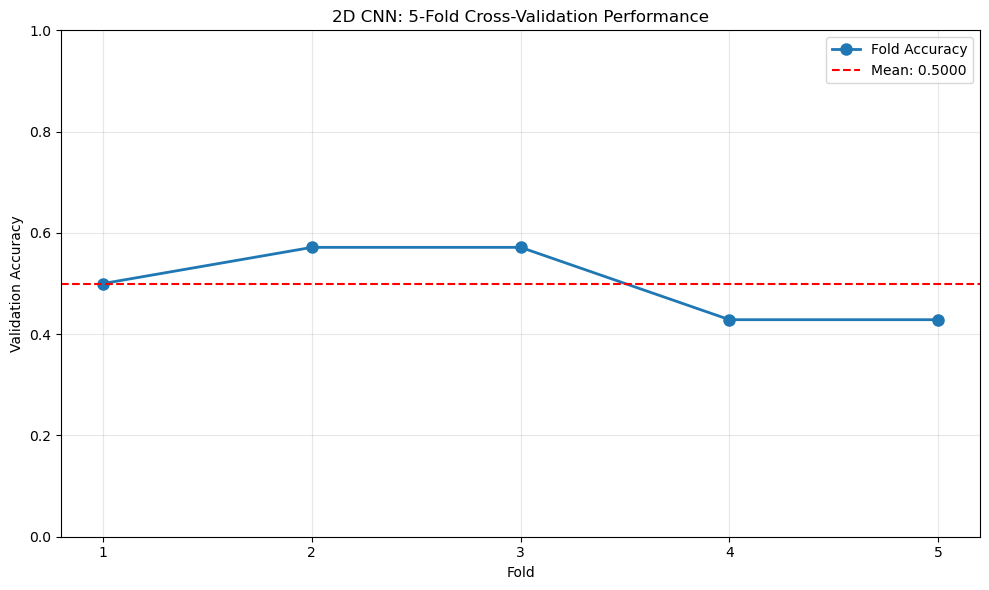


TRAINING FINAL 2D CNN ON ALL CV DATA
Final training spectrograms: 36
Final test spectrograms: 12

Training final 2D CNN on all CV data...
Epoch 1/100
4/4 [==============================] - 4s 230ms/step - loss: 0.7817 - accuracy: 0.6786 - val_loss: 0.6861 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 2/100
4/4 [==============================] - 0s 79ms/step - loss: 0.6907 - accuracy: 0.7143 - val_loss: 0.6859 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 3/100
4/4 [==============================] - 0s 79ms/step - loss: 0.4930 - accuracy: 0.7857 - val_loss: 0.6864 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 4/100
4/4 [==============================] - 0s 96ms/step - loss: 0.5540 - accuracy: 0.7857 - val_loss: 0.6892 - val_accuracy: 0.3750 - lr: 0.0010
Epoch 5/100
4/4 [==============================] - 0s 80ms/step - loss: 0.4649 - accuracy: 0.8214 - val_loss: 0.6952 - val_accuracy: 0.3750 - lr: 0.0010
Epoch 6/100
4/4 [==============================] - 0s 76ms/step - loss: 0.3676 - accuracy: 0.78

In [15]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import stft
from scipy.ndimage import uniform_filter, label, center_of_mass
import csv

print("2D CNN ON SPECTROGRAMS FROM WAV FILES WITH 5-FOLD CV")
print("=" * 50)

print("Processing WAV files to create spectrograms for 2D CNN")
print("Using 5-fold cross-validation for fair comparison")

DRIVING_DIR = Path(r"field_tests/23_03_25/radar/driving")
WALKING_DIR = Path(r"field_tests/23_03_25/radar/walking")

wav_paths = sorted(DRIVING_DIR.glob("*.wav")) + sorted(WALKING_DIR.glob("*.wav"))
print(f"found {len(wav_paths)} wav files")

# Spectrogram parameters (same as your original code)
nperseg = 4096
noverlap = int(0.75 * nperseg)
window = "hann"

def read_wav_safe(wav_path):
    """Reads a .wav file safely and prepares it for processing."""
    fs, x = wavfile.read(wav_path)
    if x is None or x.size == 0:
        raise ValueError("empty audio")
    
    if x.dtype.kind in ("i", "u"):
        maxv = np.iinfo(x.dtype).max
        x = x.astype(np.float32) / maxv
    else:
        x = x.astype(np.float32)
        
    if x.ndim == 2:
        x = x[:, 0]
    return fs, x

def create_spectrogram(x, fs, nperseg, noverlap, window):
    """Creates spectrogram from audio signal."""
    f, t, Zxx = stft(
        x, fs=fs, window=window,
        nperseg=nperseg, noverlap=noverlap,
        return_onesided=True, boundary=None
    )
    S = np.abs(Zxx)**2
    S = np.nan_to_num(S, nan=0.0, posinf=0.0, neginf=0.0)
    return f, t, S

def preprocess_spectrogram_grayscale(S, target_shape=(128, 128)):
    """Preprocess spectrogram for CNN input - GRAYSCALE version."""
    # Convert to dB scale
    S_db = 10 * np.log10(S + 1e-12)
    
    # Normalize to [0, 1] for grayscale
    S_normalized = (S_db - np.min(S_db)) / (np.max(S_db) - np.min(S_db) + 1e-12)
    
    # Resize to target shape
    from scipy.ndimage import zoom
    zoom_factors = (target_shape[0] / S_normalized.shape[0], 
                   target_shape[1] / S_normalized.shape[1])
    S_resized = zoom(S_normalized, zoom_factors)
    
    # Ensure values are in [0, 1] range for grayscale
    S_resized = np.clip(S_resized, 0, 1)
    
    return S_resized

# Process WAV files and create spectrogram dataset
spectrograms = []
labels_spectrograms = []
file_names_spectrograms = []

print("Processing WAV files into spectrograms...")
for wav_path in wav_paths:
    try:
        fs, x = read_wav_safe(wav_path)
        x = x - np.mean(x)  # Remove DC offset
        
        # Determine target type from file path
        if "driving" in str(wav_path).lower() or "car" in str(wav_path).lower():
            target_type = 0  # driving
            max_freq = 4000
        else:
            target_type = 1  # walking
            max_freq = 4000
        
        # Create spectrogram
        f_axis, t_axis, S = create_spectrogram(x, fs, nperseg, noverlap, window)
        
        # Filter frequency band
        band_mask = (f_axis >= 0) & (f_axis <= max_freq)
        f_axis_b = f_axis[band_mask]
        S_b = S[band_mask, :]
        
        # Preprocess for CNN
        S_processed = preprocess_spectrogram_grayscale(S_b, target_shape=(128, 128))
        
        spectrograms.append(S_processed)
        labels_spectrograms.append(target_type)
        file_names_spectrograms.append(wav_path.name)
        
    except Exception as e:
        print(f"Error processing {wav_path.name}: {e}")
        continue

# Convert to numpy arrays
X_spectrograms = np.array(spectrograms)
y_spectrograms = np.array(labels_spectrograms)

print(f"Created {len(spectrograms)} spectrograms")
print(f"Shape of spectrogram data: {X_spectrograms.shape}")

# Add channel dimension for CNN
X_spectrograms = X_spectrograms.reshape(X_spectrograms.shape[0], 
                                       X_spectrograms.shape[1], 
                                       X_spectrograms.shape[2], 1)

print(f"Final shape for 2D CNN: {X_spectrograms.shape}")

# Create file mapping for spectrograms
spectrogram_file_mapping = dict(zip(file_names_spectrograms, range(len(file_names_spectrograms))))

# Get the CV files for spectrograms (same as before)
cv_files_spectrograms = [f for f in files_cv if f in spectrogram_file_mapping]
cv_files_targets = [0 if 'driving' in f.lower() or 'car' in f.lower() else 1 for f in cv_files_spectrograms]

print(f"\nCV spectrogram files: {len(cv_files_spectrograms)}")
print(f"Driving: {sum(1 for t in cv_files_targets if t == 0)}, Walking: {sum(1 for t in cv_files_targets if t == 1)}")

# Perform 5-fold CV for 2D CNN
k = 5
skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

cnn_2d_fold_scores = []
cnn_2d_histories = []
cnn_2d_models = []

print(f"\nRunning {k}-Fold Cross Validation for 2D CNN...")
for fold, (train_file_idx, val_file_idx) in enumerate(skf.split(cv_files_spectrograms, cv_files_targets)):
    print(f"\nFold {fold+1}:")
    
    # Get file names for this fold
    train_files_fold = [cv_files_spectrograms[i] for i in train_file_idx]
    val_files_fold = [cv_files_spectrograms[i] for i in val_file_idx]
    
    # Get spectrogram indices for these files
    train_spec_idx = [spectrogram_file_mapping[f] for f in train_files_fold]
    val_spec_idx = [spectrogram_file_mapping[f] for f in val_files_fold]
    
    # Get spectrogram data for this fold
    X_train_fold = X_spectrograms[train_spec_idx]
    X_val_fold = X_spectrograms[val_spec_idx]
    y_train_fold = y_spectrograms[train_spec_idx]
    y_val_fold = y_spectrograms[val_spec_idx]
    
    print(f"  Train spectrograms: {len(train_files_fold)}")
    print(f"  Val spectrograms: {len(val_files_fold)}")
    print(f"  Data shapes - Train: {X_train_fold.shape}, Val: {X_val_fold.shape}")
    
    # Build 2D CNN model for this fold
    cnn_2d_fold = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    cnn_2d_fold.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    # Callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True
    )
    
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-7
    )
    
    # Train the model
    print("  Training 2D CNN...")
    history_fold = cnn_2d_fold.fit(
        X_train_fold, y_train_fold,
        validation_data=(X_val_fold, y_val_fold),
        epochs=100,  # Increased epochs for better convergence
        batch_size=8,
        callbacks=[early_stopping, reduce_lr],
        verbose=1  # Show progress
    )
    
    cnn_2d_histories.append(history_fold)
    cnn_2d_models.append(cnn_2d_fold)
    
    # Get best validation accuracy
    best_val_acc = max(history_fold.history['val_accuracy'])
    cnn_2d_fold_scores.append(best_val_acc)
    
    # Get final epoch stats
    final_train_acc = history_fold.history['accuracy'][-1]
    final_val_acc = history_fold.history['val_accuracy'][-1]
    epochs_trained = len(history_fold.history['accuracy'])
    
    print(f"  Epochs trained: {epochs_trained}")
    print(f"  Final Train Accuracy: {final_train_acc:.4f}")
    print(f"  Best Val Accuracy: {best_val_acc:.4f}")

# Calculate 5-fold CV results
cnn_2d_cv_mean = np.mean(cnn_2d_fold_scores)
cnn_2d_cv_std = np.std(cnn_2d_fold_scores)

print(f"\n" + "="*50)
print("2D CNN 5-FOLD CROSS VALIDATION RESULTS")
print("="*50)
print(f"Average CV Accuracy: {cnn_2d_cv_mean:.4f} ± {cnn_2d_cv_std*2:.4f}")
print(f"Fold scores: {[f'{score:.4f}' for score in cnn_2d_fold_scores]}")

# Plot fold performances
plt.figure(figsize=(10, 6))
plt.plot(range(1, k+1), cnn_2d_fold_scores, 'o-', linewidth=2, markersize=8, label='Fold Accuracy')
plt.axhline(y=cnn_2d_cv_mean, color='r', linestyle='--', label=f'Mean: {cnn_2d_cv_mean:.4f}')
plt.xlabel('Fold')
plt.ylabel('Validation Accuracy')
plt.title('2D CNN: 5-Fold Cross-Validation Performance')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(range(1, k+1))
plt.ylim(0, 1.0)
plt.tight_layout()
plt.show()

# Now train final model on all CV data for test evaluation
print(f"\n" + "="*50)
print("TRAINING FINAL 2D CNN ON ALL CV DATA")
print("="*50)

# Use the same train/test split as before for final evaluation
train_spectrogram_indices = []
test_spectrogram_indices = []

for file_name in files_cv:
    if file_name in spectrogram_file_mapping:
        train_spectrogram_indices.append(spectrogram_file_mapping[file_name])

for file_name in files_test:
    if file_name in spectrogram_file_mapping:
        test_spectrogram_indices.append(spectrogram_file_mapping[file_name])

print(f"Final training spectrograms: {len(train_spectrogram_indices)}")
print(f"Final test spectrograms: {len(test_spectrogram_indices)}")

X_train_spec_final = X_spectrograms[train_spectrogram_indices]
X_test_spec_final = X_spectrograms[test_spectrogram_indices]
y_train_spec_final = y_spectrograms[train_spectrogram_indices]
y_test_spec_final = y_spectrograms[test_spectrogram_indices]

# Build final 2D CNN model
cnn_2d_final = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

cnn_2d_final.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("\nTraining final 2D CNN on all CV data...")
history_2d_final = cnn_2d_final.fit(
    X_train_spec_final, y_train_spec_final,
    validation_split=0.2,  # Keep some validation for monitoring
    epochs=100,
    batch_size=8,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Evaluate on test set
test_loss_2d, test_acc_2d = cnn_2d_final.evaluate(X_test_spec_final, y_test_spec_final, verbose=0)
train_acc_2d = history_2d_final.history['accuracy'][-1]
val_acc_2d = history_2d_final.history['val_accuracy'][-1]

print(f"\n2D CNN Final Results:")
print(f"Train Accuracy: {train_acc_2d:.4f}")
print(f"Val Accuracy: {val_acc_2d:.4f}")
print(f"Test Accuracy: {test_acc_2d:.4f}")

# Add to results with proper 5-fold CV metrics
final_results['2D CNN'] = {
    'cv_mean': cnn_2d_cv_mean,  # Proper 5-fold CV mean
    'cv_std': cnn_2d_cv_std,    # Proper 5-fold CV std
    'test_accuracy': test_acc_2d
}

print(f"\nSUMMARY:")
print(f"5-Fold CV: {cnn_2d_cv_mean:.1%} ± {cnn_2d_cv_std*2:.1%}")
print(f"Test Accuracy: {test_acc_2d:.1%}")

In [16]:
print("FINAL MODEL COMPARISON - ALL APPROACHES")
print("=" * 50)

print("Comparing traditional ML with deep learning approaches")
print("All models evaluated with the same file-level splits")

# Update final results table with deep learning models
final_df_updated = pd.DataFrame(final_results).T.round(4)
final_df_updated = final_df_updated.sort_values('test_accuracy', ascending=False)

print("\n" + "=" * 70)
print("COMPREHENSIVE RESULTS - ALL MODELS")
print("=" * 70)
print(final_df_updated)

print(f"\nPERFORMANCE RANKING:")
print("=" * 45)
for i, (model_name, results) in enumerate(final_results.items(), 1):
    test_acc = results['test_accuracy']
    print(f"{i}. {model_name:20} - Test Accuracy: {test_acc:.1%}")

print(f"\nKEY FINDINGS:")
print(f"Best Traditional: {final_df_updated.index[0]} - {final_df_updated.iloc[0]['test_accuracy']:.1%}")
if '1D CNN' in final_results:
    print(f"1D CNN Performance: {final_results['1D CNN']['test_accuracy']:.1%}")
if '2D CNN' in final_results:
    print(f"2D CNN Performance: {final_results['2D CNN']['test_accuracy']:.1%}")

print(f"\nDEEP LEARNING INSIGHTS:")
if '1D CNN' in final_results and '2D CNN' in final_results:
    cnn_1d_acc = final_results['1D CNN']['test_accuracy']
    cnn_2d_acc = final_results['2D CNN']['test_accuracy']
    best_traditional = final_df_updated.iloc[0]['test_accuracy']

FINAL MODEL COMPARISON - ALL APPROACHES
Comparing traditional ML with deep learning approaches
All models evaluated with the same file-level splits

COMPREHENSIVE RESULTS - ALL MODELS
                     cv_mean  cv_std  test_accuracy
MLP                   0.9359  0.0485         0.9373
Random Forest         0.9340  0.0585         0.9331
SVM RBF               0.9348  0.0372         0.9329
Gradient Boosting     0.9316  0.0535         0.9230
2D CNN                0.5000  0.0639         0.9167
1D CNN                0.9413  0.0170         0.9052
SVM Linear            0.9108  0.0387         0.8741
Logistic Regression   0.8945  0.0428         0.8692

PERFORMANCE RANKING:
1. Logistic Regression  - Test Accuracy: 86.9%
2. SVM Linear           - Test Accuracy: 87.4%
3. SVM RBF              - Test Accuracy: 93.3%
4. Random Forest        - Test Accuracy: 93.3%
5. Gradient Boosting    - Test Accuracy: 92.3%
6. MLP                  - Test Accuracy: 93.7%
7. 1D CNN               - Test Accuracy: 90.

CREATING FIGURES FOR RESULTS SECTION


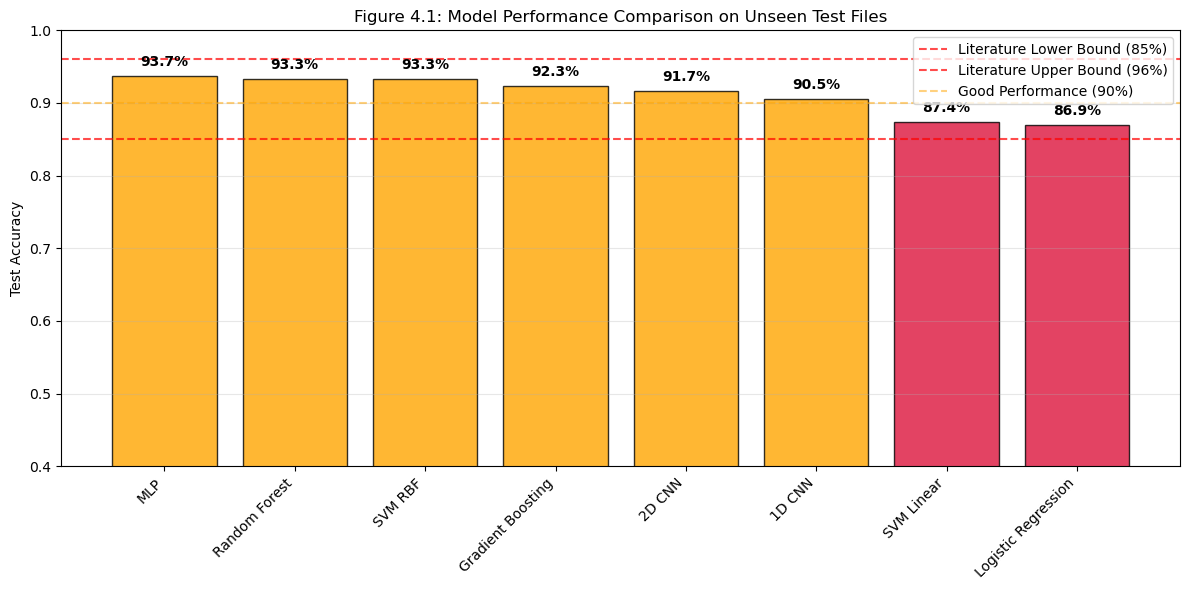

Figure 4.1: Model Performance Comparison Bar Chart - COMPLETED


In [17]:
print("CREATING FIGURES FOR RESULTS SECTION")
print("=" * 50)

# Figure 4.1: Model Performance Comparison Bar Chart
plt.figure(figsize=(12, 6))
models_plot = list(final_results.keys())
test_accuracies = [final_results[model]['test_accuracy'] for model in models_plot]

# Sort by accuracy
sorted_indices = np.argsort(test_accuracies)[::-1]
models_sorted = [models_plot[i] for i in sorted_indices]
accuracies_sorted = [test_accuracies[i] for i in sorted_indices]

colors = ['#2E8B57' if acc > 0.95 else '#FFA500' if acc > 0.90 else '#DC143C' for acc in accuracies_sorted]

bars = plt.bar(models_sorted, accuracies_sorted, color=colors, alpha=0.8, edgecolor='black')
plt.axhline(y=0.85, color='red', linestyle='--', alpha=0.7, label='Literature Lower Bound (85%)')
plt.axhline(y=0.96, color='red', linestyle='--', alpha=0.7, label='Literature Upper Bound (96%)')
plt.axhline(y=0.90, color='orange', linestyle='--', alpha=0.5, label='Good Performance (90%)')

plt.ylabel('Test Accuracy')
plt.title('Figure 4.1: Model Performance Comparison on Unseen Test Files')
plt.xticks(rotation=45, ha='right')
plt.ylim(0.4, 1.0)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, acc in zip(bars, accuracies_sorted):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{acc:.1%}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("Figure 4.1: Model Performance Comparison Bar Chart - COMPLETED")

COMPARISON OF CROSS-VALIDATION VS TEST PERFORMANCE


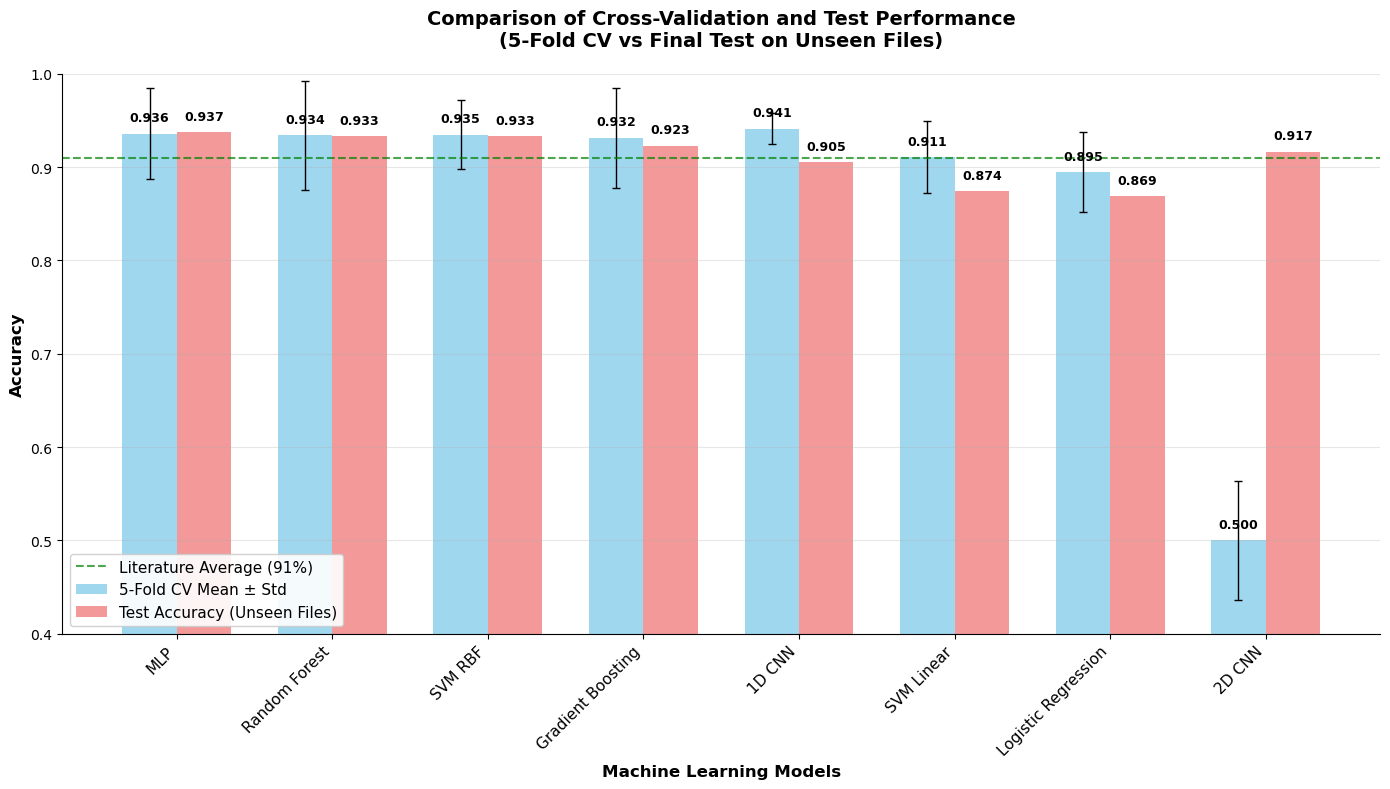


PERFORMANCE SUMMARY: CROSS-VALIDATION VS TEST
Model                CV Mean    CV Std     Test Acc     Diff (Test-CV) 
----------------------------------------------------------------------
MLP                  0.9359     0.0485     0.9373       +0.0014        
Random Forest        0.9340     0.0585     0.9331       -0.0009        
SVM RBF              0.9348     0.0372     0.9329       -0.0019        
Gradient Boosting    0.9316     0.0535     0.9230       -0.0086        
1D CNN               0.9413     0.0170     0.9052       -0.0361        
SVM Linear           0.9108     0.0387     0.8741       -0.0367        
Logistic Regression  0.8945     0.0428     0.8692       -0.0253        
2D CNN               0.5000     0.0639     0.9167       +0.4167        
----------------------------------------------------------------------
Average              0.8729     -          0.9114       +0.0386


In [18]:
print("COMPARISON OF CROSS-VALIDATION VS TEST PERFORMANCE")
print("=" * 50)

import matplotlib.pyplot as plt
import numpy as np

# Prepare data for plotting
models_ordered = [
    'MLP', 'Random Forest', 'SVM RBF', 'Gradient Boosting', 
    '1D CNN', 'SVM Linear', 'Logistic Regression', '2D CNN'
]

cv_means = [final_results[model]['cv_mean'] for model in models_ordered]
cv_stds = [final_results[model]['cv_std'] for model in models_ordered]
test_accuracies = [final_results[model]['test_accuracy'] for model in models_ordered]

# Create the comparison plot
plt.figure(figsize=(14, 8))

# Set up positions and width
x = np.arange(len(models_ordered))
width = 0.35

# Create bars
bars1 = plt.bar(x - width/2, cv_means, width, yerr=cv_stds, 
                capsize=5, label='5-Fold CV Mean ± Std', 
                color='skyblue', alpha=0.8, error_kw=dict(lw=1, capsize=3, capthick=1))

bars2 = plt.bar(x + width/2, test_accuracies, width, 
                label='Test Accuracy (Unseen Files)', 
                color='lightcoral', alpha=0.8)

# Add value labels on bars
def add_value_labels(bars, is_cv=False):
    for i, bar in enumerate(bars):
        height = bar.get_height()
        if is_cv:
            # For CV bars, show mean value only
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom', 
                    fontsize=9, fontweight='bold')
        else:
            # For test bars, show value
            plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom', 
                    fontsize=9, fontweight='bold')

add_value_labels(bars1, is_cv=True)
add_value_labels(bars2, is_cv=False)

# Customize the plot
plt.xlabel('Machine Learning Models', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy', fontsize=12, fontweight='bold')
plt.title('Comparison of Cross-Validation and Test Performance\n(5-Fold CV vs Final Test on Unseen Files)', 
          fontsize=14, fontweight='bold', pad=20)

plt.xticks(x, models_ordered, rotation=45, ha='right', fontsize=11)
plt.legend(loc='lower left', framealpha=0.9, fontsize=11)

# Add grid and styling
plt.grid(True, alpha=0.3, axis='y')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Set y-axis limits
plt.ylim(0.4, 1.0)

# Add horizontal line for literature average
plt.axhline(y=0.91, color='green', linestyle='--', alpha=0.7, 
            label='Literature Average (91%)')

plt.legend(loc='lower left', framealpha=0.9, fontsize=11)

plt.tight_layout()

# Save the plot
plt.savefig('cv_vs_test_comparison.png', dpi=300, bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.savefig('cv_vs_test_comparison.pdf', bbox_inches='tight', 
            facecolor='white', edgecolor='none')
plt.show()

# Print performance summary table
print(f"\n" + "="*70)
print("PERFORMANCE SUMMARY: CROSS-VALIDATION VS TEST")
print("="*70)
print(f"{'Model':<20} {'CV Mean':<10} {'CV Std':<10} {'Test Acc':<12} {'Diff (Test-CV)':<15}")
print("-" * 70)
for model in models_ordered:
    cv_mean = final_results[model]['cv_mean']
    cv_std = final_results[model]['cv_std']
    test_acc = final_results[model]['test_accuracy']
    diff = test_acc - cv_mean
    diff_str = f"{diff:+.4f}"
    
    print(f"{model:<20} {cv_mean:<10.4f} {cv_std:<10.4f} {test_acc:<12.4f} {diff_str:<15}")

print("-" * 70)

# Calculate overall statistics
avg_cv = np.mean(cv_means)
avg_test = np.mean(test_accuracies)
print(f"{'Average':<20} {avg_cv:<10.4f} {'-':<10} {avg_test:<12.4f} {avg_test - avg_cv:+.4f}")